In [1]:
%run env_setup.py
%matplotlib notebook

In [2]:
from matplotlib import pyplot as plt
#from tensorflow.contrib import keras
import keras
from keras import backend as K
import numpy as np
import bcolz
from lessdeep.utils import download_file, extract_file
from lessdeep.model.vgg16n import Vgg16N

D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Super resolution

In [3]:
resized_72_path = extract_file(download_file('http://files.fast.ai/data/trn_resized_72.tar.gz'))
resized_288_path = extract_file(download_file('http://files.fast.ai/data/trn_resized_288.tar.gz'))

In [4]:
arr_lr = bcolz.open(resized_72_path)[:] # Low resolution
arr_hr = bcolz.open(resized_288_path)[:] # High resolution

In [5]:
def conv_block(x, filters, size, strides=(2,2), padding='same', activation='relu'):
    x = keras.layers.Conv2D(filters, kernel_size=size, strides=strides, padding=padding)(x)
    x = keras.layers.BatchNormalization()(x)
    return keras.layers.Activation(activation)(x) if activation else x

def res_block(x, filters=64):
    y = conv_block(x, filters, 3, strides=(1,1))
    y = conv_block(y, filters, 3, strides=(1,1), activation=None)
    return keras.layers.add([y, x])

def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = keras.layers.Conv2D(filters, size, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    return keras.layers.Activation('relu')(x)

def deconv_block(x, filters, size, strides=(2,2)):
    x = keras.layers.Conv2DTranspose(filters, size, strides=strides, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    return keras.layers.Activation('relu')(x)

In [6]:
image_net_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
def pre_proc(imgs):
    return (imgs - image_net_mean)[:,:,:, ::-1]  # VGG use BGR

def de_proc(imgs):
    return imgs[:,:,:, ::-1] + image_net_mean  # VGG use BGR

In [31]:
inp = keras.layers.Input(arr_lr.shape[1:])
x = conv_block(inp, 64, 9, strides=(1,1))
for _ in range(4):
    x = res_block(x)
x = up_block(x, 64, 3)
x = up_block(x, 64, 3)
x = keras.layers.Conv2D(3, 9, activation='tanh', padding='same')(x)
out = keras.layers.Lambda(lambda x: (x + 1)*127.5)(x)

In [8]:
vgg = Vgg16N(include_top=False, image_size=arr_hr.shape[1:3])
vgg_inp = keras.layers.Input(shape=arr_hr.shape[1:])
#vgg_inp = vgg.model.input_layers[0]

In [9]:
for l in vgg.model.layers: l.trainable=False

In [32]:
def get_layer_out(model, i):
    return model.model.layers[i].output

#wrapped_vgg = vgg.model(keras.layers.Lambda(pre_proc)(vgg_inp))
conv_layers = keras.models.Model(vgg.model.input, [get_layer_out(vgg, i) for i in [1, 4, 7]])
vgg1 = conv_layers(keras.layers.Lambda(pre_proc)(out))
vgg2 = conv_layers(keras.layers.Lambda(pre_proc)(vgg_inp))

In [33]:
def mean_sqr(diff):
    mean_axis = tuple(range(1, K.ndim(diff)))
    #return K.expand_dims(K.mean(K.sqrt(diff**2), axis=mean_axis), axis=0)
    print(diff)
    print(K.expand_dims(K.sqrt(K.mean(diff**2, axis=mean_axis)), axis=0))
    print(K.expand_dims(K.sqrt(K.mean(diff**2, axis=mean_axis)), axis=1))
    return K.expand_dims(K.sqrt(K.mean(diff**2, axis=mean_axis)), axis=0)

def lost_func(vec_concat):
    weight = [0.1, 0.8, 0.1]
    n = len(weight)
    res = 0
    for i, w in enumerate(weight):
        res += mean_sqr(vec_concat[i] - vec_concat[i+n]) * w
    return res

In [34]:
content_lost = keras.Model([inp, vgg_inp], keras.layers.Lambda(lost_func)(vgg1 + vgg2))

Tensor("lambda_12/sub:0", shape=(?, 288, 288, 64), dtype=float32)
Tensor("lambda_12/ExpandDims:0", shape=(1, ?), dtype=float32)
Tensor("lambda_12/ExpandDims_1:0", shape=(?, 1), dtype=float32)
Tensor("lambda_12/sub_1:0", shape=(?, 144, 144, 128), dtype=float32)
Tensor("lambda_12/ExpandDims_3:0", shape=(1, ?), dtype=float32)
Tensor("lambda_12/ExpandDims_4:0", shape=(?, 1), dtype=float32)
Tensor("lambda_12/sub_2:0", shape=(?, 72, 72, 256), dtype=float32)
Tensor("lambda_12/ExpandDims_6:0", shape=(1, ?), dtype=float32)
Tensor("lambda_12/ExpandDims_7:0", shape=(?, 1), dtype=float32)
Tensor("lambda_12/sub_3:0", shape=(?, 288, 288, 64), dtype=float32)
Tensor("lambda_12/ExpandDims_9:0", shape=(1, ?), dtype=float32)
Tensor("lambda_12/ExpandDims_10:0", shape=(?, 1), dtype=float32)
Tensor("lambda_12/sub_4:0", shape=(?, 144, 144, 128), dtype=float32)
Tensor("lambda_12/ExpandDims_12:0", shape=(1, ?), dtype=float32)
Tensor("lambda_12/ExpandDims_13:0", shape=(?, 1), dtype=float32)
Tensor("lambda_12/su

In [35]:
tgt = np.zeros((len(arr_hr), 1))

In [37]:
content_lost.compile(keras.optimizers.Adam(), 'mse')

In [38]:
from keras_tqdm import TQDMNotebookCallback
fit_param = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [72]:
content_lost.fit([arr_lr, arr_hr], tgt, batch_size=16, epochs=2, **fit_param)

In [71]:
K.set_value(content_lost.optimizer.lr, 0.0001)

In [46]:
top_model = keras.Model(inp, out)

In [61]:
def image_compare(*imgs):
    fig, axes = plt.subplots(1,len(imgs), figsize=(10, 5))
    for ax, img in zip(axes, imgs):
        ax.imshow(img.astype(int))
    plt.show()

<IPython.core.display.Javascript object>


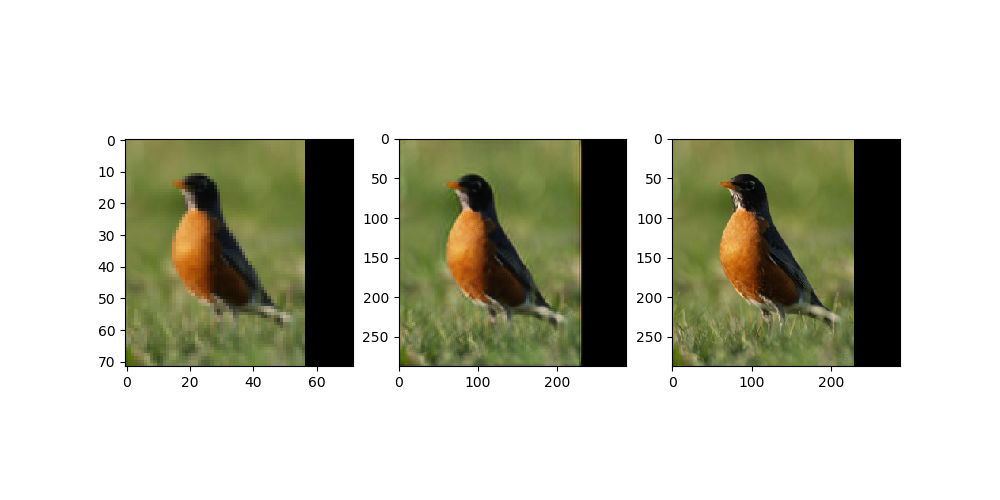

In [81]:
display_idx = 45
image_compare(arr_lr[display_idx], top_model.predict(arr_lr[display_idx:display_idx+1])[0], arr_hr[display_idx])